# Laboratorium 2 - Klasyfikacja algorytmem k-najbliższych sąsiadów (k-nn)

In [62]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut, RepeatedStratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, Normalizer

### Klasyfikacja k-nn dla zbioru IRIS

In [2]:
iris = load_iris()
df_iris = pd.DataFrame(data = iris.data, columns = iris.feature_names)
df_iris['target'] = iris.target
df_iris['target names'] = iris.target_names[df_iris['target']]
df_iris.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,target names
0,5.1,3.5,1.4,0.2,0,setosa
1,4.9,3.0,1.4,0.2,0,setosa
2,4.7,3.2,1.3,0.2,0,setosa
3,4.6,3.1,1.5,0.2,0,setosa
4,5.0,3.6,1.4,0.2,0,setosa


In [3]:
# Dystrybucja klas w zbiorze
class_labels = iris.target
unique_classes, counts = np.unique(class_labels, return_counts = True)

for i, class_name in enumerate(iris.target_names):
    print(f'{class_name}: {counts[i]}')

setosa: 50
versicolor: 50
virginica: 50


In [4]:
df_iris.isna().any()

sepal length (cm)    False
sepal width (cm)     False
petal length (cm)    False
petal width (cm)     False
target               False
target names         False
dtype: bool

In [5]:
df_iris.iloc[:, :4].columns

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')

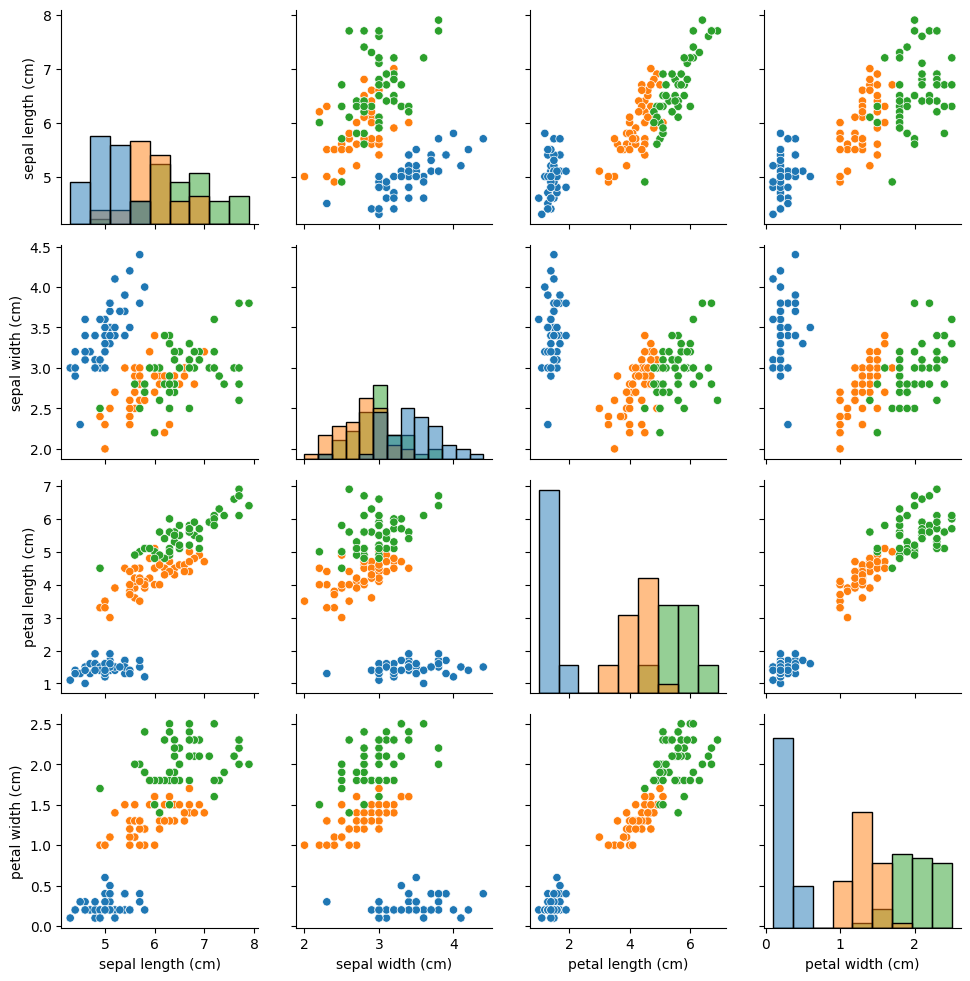

In [6]:
x_vars = df_iris.iloc[:, :4].columns
y_vars = x_vars

g = sns.PairGrid(df_iris, hue = 'target names', x_vars = x_vars, y_vars = y_vars)
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
plt.show()

In [7]:
X_iris = df_iris.iloc[:, :4]
y_iris = df_iris['target']

scaler = MinMaxScaler()
normalizer = Normalizer()
X_iris_standardized = scaler.fit_transform(X_iris)
X_iris_normalized = normalizer.fit_transform(X_iris)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_iris_standardized, y_iris, stratify = y_iris, random_state = 42)

neigh = KNeighborsClassifier()
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      0.87      0.93        15
           2       0.85      1.00      0.92        11

    accuracy                           0.95        38
   macro avg       0.95      0.96      0.95        38
weighted avg       0.96      0.95      0.95        38



In [9]:
X_train, X_test, y_train, y_test = train_test_split(X_iris, y_iris, stratify = y_iris, random_state = 42)

neigh = KNeighborsClassifier()
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)

print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      0.93      0.96        14
           2       0.92      1.00      0.96        12

    accuracy                           0.97        38
   macro avg       0.97      0.98      0.97        38
weighted avg       0.98      0.97      0.97        38



In [27]:
X_train, X_test, y_train, y_test = train_test_split(X_iris_normalized, y_iris, stratify = y_iris, random_state = 42)

neigh = KNeighborsClassifier()
neigh.fit(X_train, y_train)
y_pred = neigh.predict(X_test)

print(classification_report(y_pred, y_test))
print(f'Confision matrix: \n{confusion_matrix(y_pred, y_test)}')
print(f'Accuracy: {accuracy_score(y_pred, y_test)}')
print(f'Precision: {precision_score(y_pred, y_test, average = None)}')
print(f'Recall: {recall_score(y_pred, y_test, average = None)}')
print(f'F1: {f1_score(y_pred, y_test, average = None)}')

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       0.92      1.00      0.96        12
           2       1.00      0.93      0.96        14

    accuracy                           0.97        38
   macro avg       0.97      0.98      0.97        38
weighted avg       0.98      0.97      0.97        38

Confision matrix: 
[[12  0  0]
 [ 0 12  0]
 [ 0  1 13]]
Accuracy: 0.9736842105263158
Precision: [1.         0.92307692 1.        ]
Recall: [1.         1.         0.92857143]
F1: [1.         0.96       0.96296296]


### 4. Implementacja procedury walidacji krzyżowej

In [66]:
def cv_knn(n_splits, X = X_iris_normalized, y = y_iris, shuffle = True):

    kf = KFold(n_splits = n_splits, shuffle = shuffle)
    knn = KNeighborsClassifier()
    scores = []
    
    for train_index, test_index in kf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        scores.append(score)

    # Średnia dokładność z k-fold walidacji
    mean_score = np.mean(scores)
    return mean_score


def loo_knn(X = X_iris_normalized, y = y_iris):

    loo = LeaveOneOut()
    loo.get_n_splits(X)
    knn = KNeighborsClassifier()
    scores = []
    
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        knn.fit(X_train, y_train)
        y_pred = knn.predict(X_test)
        score = accuracy_score(y_test, y_pred)
        scores.append(score)

    # Średnia dokładność z k-fold walidacji
    mean_score = np.mean(scores)
    return mean_score

In [60]:
print('KFold accuracy without shuffling: \n')
print(f'2-fold CV accuracy: {cv_knn(2, shuffle = False)}')
print(f'5-fold CV accuracy: {cv_knn(5, shuffle = False)}')
print(f'10-fold CV accuracy: {cv_knn(10, shuffle = False)}')

KFold accuracy without shuffling: 

2-fold CV accuracy: 0.30666666666666664
5-fold CV accuracy: 0.9400000000000001
10-fold CV accuracy: 0.9533333333333334


In [61]:
print('KFold accuracy with shuffling: \n')
print(f'2-fold CV accuracy: {cv_knn(2)}')
print(f'5-fold CV accuracy: {cv_knn(5)}')
print(f'10-fold CV accuracy: {cv_knn(10)}')

KFold accuracy with shuffling: 

2-fold CV accuracy: 0.9733333333333334
5-fold CV accuracy: 0.9666666666666668
10-fold CV accuracy: 0.9666666666666668


In [67]:
print('LeaveOneOut accuracy: \n')
print(f'LOO accuracy: {loo_knn()}')


LeaveOneOut accuracy: 

LOO accuracy: 0.9666666666666667
